# Aujourd'hui on se fait rouler par les mecs de l'ENS


https://challengedata.ens.fr/en/challenge/39/prediction_of_transaction_claims_status.html


Ici, c'est le notebook dédié au feature enginering - aka: le plus important de tous

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python

#load packages
import sys #access to system parameters https://docs.python.org/3/library/sys.html
print("Python version: {}". format(sys.version))

import pandas as pd #collection of functions for data processing and analysis modeled after R dataframes with SQL like features
print("pandas version: {}". format(pd.__version__))

import matplotlib #collection of functions for scientific and publication-ready visualization
print("matplotlib version: {}". format(matplotlib.__version__))

import numpy as np #foundational package for scientific computing
print("NumPy version: {}". format(np.__version__))

import scipy as sp #collection of functions for scientific computing and advance mathematics
print("SciPy version: {}". format(sp.__version__)) 

import IPython
from IPython import display #pretty printing of dataframes in Jupyter notebook
print("IPython version: {}". format(IPython.__version__)) 

import sklearn #collection of machine learning algorithms
print("scikit-learn version: {}". format(sklearn.__version__))

import seaborn as sns
print("seaborn version: {}". format(sns.__version__))

#misc libraries
import time
import random as rnd
import os, gc

#ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

Python version: 3.6.3 |Anaconda custom (64-bit)| (default, Oct 15 2017, 03:27:45) [MSC v.1900 64 bit (AMD64)]
pandas version: 0.22.0
matplotlib version: 2.1.2
NumPy version: 1.12.1
SciPy version: 1.0.0
IPython version: 6.2.1
scikit-learn version: 0.19.1
seaborn version: 0.8.1
-------------------------


Moi j'ai ça:

Python version: 3.6.3 |Anaconda custom (64-bit)| (default, Oct 15 2017, 03:27:45) [MSC v.1900 64 bit (AMD64)]

pandas version: 0.22.0

matplotlib version: 2.1.2

NumPy version: 1.12.1

SciPy version: 1.0.0

IPython version: 6.2.1

scikit-learn version: 0.19.1

seaborn version: 0.8.1


# Définition de la seed pour le random

Très important pour qu'on voit les mêmes choses entre nos deux ordis

In [2]:
RANDOM_SEED = 42;
np.random.seed(RANDOM_SEED)

In [3]:
# Run "! pip install jyquickhelper" dans une cellule si ca ne marche pas la commande suivante
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [4]:
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

## Chargement des données

In [5]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
DATA_PROCESSED = os.path.join(PROJECT_ROOT_DIR, "data_processed")

def load_data(file,data_path=DATA_PROCESSED, sep=','):
    csv_path = os.path.join(data_path, file)
    return pd.read_csv(csv_path, sep)

train_df = load_data(file = "train_notebook_1.csv", sep=';');
test_df = load_data(file = "test_notebook_1.csv", sep=';');

## Analyse des types de données

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 22 columns):
SHIPPING_MODE           100000 non-null object
SHIPPING_PRICE          100000 non-null int64
WARRANTIES_FLG          100000 non-null bool
WARRANTIES_PRICE        100000 non-null int64
CARD_PAYMENT            100000 non-null int64
COUPON_PAYMENT          100000 non-null int64
RSP_PAYMENT             100000 non-null int64
WALLET_PAYMENT          100000 non-null int64
PRICECLUB_STATUS        100000 non-null int64
REGISTRATION_DATE       100000 non-null int64
PURCHASE_COUNT          100000 non-null int64
BUYER_BIRTHDAY_DATE     100000 non-null float64
BUYER_DEPARTMENT        100000 non-null int64
BUYING_DATE             100000 non-null int64
SELLER_SCORE_COUNT      100000 non-null int64
SELLER_SCORE_AVERAGE    100000 non-null float64
SELLER_COUNTRY          100000 non-null object
SELLER_DEPARTMENT       100000 non-null int64
PRODUCT_TYPE            100000 non-null object
PRODUCT_FA

## Plan d'action:

Idées de features engineering:
1. Taux de couverture de la garantie -> `WARRANTY_COV_RATE`. Ou faire la perte en cas de claim 
2. Classer les `SHIPPING_MODE` en fonction de leurs prix et/ou des services proposés
3. `SELLER_COUNTRY` en fonction de leurs PIB/habitants -> `SELLER_COUNTRY_PIB`
4. La densité de population par departement, pour montrer les grosses villes ou non (densité parce que 2 infos : nombre/superficie) -> `BUYER_DEPARTMENT_DENSITY` & `SELLER_DEPARTMENT_DENSITY`
5. Les PIB des départements -> `BUYER_DEPARTMENT_PIB` & `SELLER_DEPARTMENT_PIB`
6. Le niveau d'économie générale -> `CAC_POINTS` & `CAC_VAR`
7. A au moins une semaine de vacances scolaires dans le mois -> `IS_HOLIDAYS`
8. A des soldes dans le mois -> `IS_SALES`
9. Le niveau de température par mois -> `TEMPERATURE` (pas encore faite)
10. Le taux de chomage par départements -> `UNEMPLOYMENT` (pas urgent, certainement très corrélé avec le PIB)


Trouver un moyen de retrouver les clients via les données personelles 

Je vais utiliser que des `pandas.Series.map(arg, na_action=None)` pour s'assurer de ne pas laisser des trous dans la raquette.

A chaque fois j'utilise un `mapper` qui ressemble à `{valeur_à_remplacer_1: nouvelle_valeur_1, valeur_à_remplacer_2: nouvelle_valeur_2, etc...}`.

Aussi, je vais remplacer les valeurs manquante des départements par des valeurs extrèmes comme des `-9999` ou `-99` en fonction de l'intervalle de la variable

In [7]:
#train_df.info()
#print('_'*40)
#test_df.info()

## Travaux sur WARRANTY

### WARRANTY_COV_RATE

In [8]:
## ITEM_PRICE
print(train_df.ITEM_PRICE.sort_values().unique())
print(test_df.ITEM_PRICE.sort_values().unique())

[0 1 2 3 4 5 6]
[0 1 2 3 4 5 6]


In [9]:
## WARRANTIES_PRICE
print(train_df.WARRANTIES_PRICE.sort_values().unique())
print(test_df.WARRANTIES_PRICE.sort_values().unique())

[0 1 2 3 4 5]
[0 1 2 3 4 5]


Bon, comme il y a des 0 dans les Item Prices, on va devoir faire (WARRANTIES_PRICE)/(ITEM_PRICE+1)

In [10]:
train_df['WARRANTY_COV_RATE'] = (train_df.WARRANTIES_PRICE)/(train_df.ITEM_PRICE+1)
test_df['WARRANTY_COV_RATE'] = (test_df.WARRANTIES_PRICE)/(test_df.ITEM_PRICE+1)

## Travaux sur SELLER COUNTRY

1. L'indice de Gini
2. Le PIB per capita
3. Distance de capitale à capitale

In [11]:
print(train_df.SELLER_COUNTRY.sort_values().unique())
print(test_df.SELLER_COUNTRY.sort_values().unique())

['ANDORRA' 'AUSTRIA' 'BELGIUM' 'BULGARIA' 'CANADA' 'CHINA' 'CYPRUS'
 'ESTONIA' 'FRANCE, METROPOLITAN' 'GERMANY' 'GIBRALTAR' 'GREECE' 'GUYANA'
 'HONG KONG' 'IRELAND' 'ISRAEL' 'ITALY' 'JAPAN' 'JERSEY' 'LATVIA'
 'LIECHTENSTEIN' 'LITHUANIA' 'LUXEMBOURG' 'MALAYSIA' 'MALTA' 'MARTINIQUE'
 'NETHERLANDS' 'POLAND' 'PORTUGAL' 'ROMANIA' 'SINGAPORE'
 'SLOVAKIA (Slovak Republic)' 'SLOVENIA' 'SPAIN' 'SWEDEN' 'SWITZERLAND'
 'UNITED KINGDOM' 'UNITED STATES' 'VATICAN CITY STATE (HOLY SEE)']
['ANDORRA' 'AUSTRIA' 'BELGIUM' 'BULGARIA' 'CANADA' 'CHINA' 'ESTONIA'
 'FRANCE, METROPOLITAN' 'GERMANY' 'GIBRALTAR' 'GUYANA' 'HONG KONG'
 'IRELAND' 'ISRAEL' 'ITALY' 'JAPAN' 'JERSEY' 'LATVIA' 'LIECHTENSTEIN'
 'LUXEMBOURG' 'MALAYSIA' 'MARTINIQUE' 'NETHERLANDS' 'POLAND' 'PORTUGAL'
 'ROMANIA' 'SINGAPORE' 'SLOVAKIA (Slovak Republic)' 'SLOVENIA' 'SPAIN'
 'SWEDEN' 'SWITZERLAND' 'UNITED KINGDOM' 'UNITED STATES'
 'VATICAN CITY STATE (HOLY SEE)']


### SELLER_COUNTRY_GINI

In [12]:
'''

mapper={'ANDORRA':27, 'AUSTRIA':30, 'BELGIUM':28, 'BULGARIA':37, 'CANADA':34, 'CHINA':42, 'CYPRUS':35, 'ESTONIA':34, 'FRANCE, METROPOLITAN':32, 'GERMANY':31, 'GIBRALTAR':34, 'GREECE':35, 'GUYANA':44, 'HONG KONG':42, 'IRELAND':31, 'ISRAEL':42, 'ITALY':34, 'JAPAN':32, 'JERSEY':34, 'LATVIA':35, 'LIECHTENSTEIN':31, 'LITHUANIA':37, 'LUXEMBOURG':31, 'MALAYSIA':46, 'MALTA':27, 'MARTINIQUE':37, 'NETHERLANDS':28, 'POLAND':32, 'PORTUGAL':35, 'ROMANIA':27, 'SINGAPORE':47, 'SLOVAKIA (Slovak Republic)':26, 'SLOVENIA':25, 'SPAIN':36, 'SWEDEN':27, 'SWITZERLAND':32, 'UNITED KINGDOM':34, 'UNITED STATES':41, 'VATICAN CITY STATE (HOLY SEE)':34}

train_df['SELLER_COUNTRY_GINI'] = train_df.SELLER_COUNTRY.map(mapper)
test_df['SELLER_COUNTRY_GINI'] = test_df.SELLER_COUNTRY.map(mapper)

'''

"\n\nmapper={'ANDORRA':27, 'AUSTRIA':30, 'BELGIUM':28, 'BULGARIA':37, 'CANADA':34, 'CHINA':42, 'CYPRUS':35, 'ESTONIA':34, 'FRANCE, METROPOLITAN':32, 'GERMANY':31, 'GIBRALTAR':34, 'GREECE':35, 'GUYANA':44, 'HONG KONG':42, 'IRELAND':31, 'ISRAEL':42, 'ITALY':34, 'JAPAN':32, 'JERSEY':34, 'LATVIA':35, 'LIECHTENSTEIN':31, 'LITHUANIA':37, 'LUXEMBOURG':31, 'MALAYSIA':46, 'MALTA':27, 'MARTINIQUE':37, 'NETHERLANDS':28, 'POLAND':32, 'PORTUGAL':35, 'ROMANIA':27, 'SINGAPORE':47, 'SLOVAKIA (Slovak Republic)':26, 'SLOVENIA':25, 'SPAIN':36, 'SWEDEN':27, 'SWITZERLAND':32, 'UNITED KINGDOM':34, 'UNITED STATES':41, 'VATICAN CITY STATE (HOLY SEE)':34}\n\ntrain_df['SELLER_COUNTRY_GINI'] = train_df.SELLER_COUNTRY.map(mapper)\ntest_df['SELLER_COUNTRY_GINI'] = test_df.SELLER_COUNTRY.map(mapper)\n\n"

### SELLER_COUNTRY_PIB

PIB per capita

In [13]:
mapper={ 'ANDORRA':40215, 'AUSTRIA':49038, 'BELGIUM':45537, 'BULGARIA':7328, 'CANADA':52037, 'CHINA':6958, 'CYPRUS':24866, 'ESTONIA':18852, 'FRANCE, METROPOLITAN':44098, 'GERMANY':44999, 'GIBRALTAR': 38200, 'GREECE':21857, 'GUYANA':3755, 'HONG KONG':37955, 'IRELAND':48607, 'ISRAEL':36926, 'ITALY':34714, 'JAPAN':38467, 'JERSEY':49500, 'LATVIA':15187, 'LIECHTENSTEIN':179478, 'LUXEMBOURG':112472, 'LITHUANIA':15648, 'MALAYSIA':10456, 'MALTA':22892, 'MARTINIQUE':10700, 'NETHERLANDS':50815, 'POLAND':13435, 'PORTUGAL':20995, 'ROMANIA':8873, 'SINGAPORE':55182, 'SLOVAKIA (Slovak Republic)':16499, 'SLOVENIA':23316, 'SPAIN':29150, 'SWEDEN':58014, 'SWITZERLAND':81276, 'UNITED KINGDOM':39371, 'UNITED STATES':53000, 'VATICAN CITY STATE (HOLY SEE)':21198 }

train_df['SELLER_COUNTRY_PIB'] = train_df.SELLER_COUNTRY.map(mapper)
test_df['SELLER_COUNTRY_PIB'] = test_df.SELLER_COUNTRY.map(mapper)

### SELLER_COUNTRY_DISTANCE

Calcule la distance de la capitale du vendeur jusqu'a Paris en vol d'oiseau

In [14]:
mapper={ 'ANDORRA':709, 'AUSTRIA':1037, 'BELGIUM':264, 'BULGARIA':1761, 'CANADA':5665, 'CHINA':8237, 'CYPRUS':2954, 'ESTONIA':1863, 'FRANCE, METROPOLITAN':0, 'GERMANY':878, 'GIBRALTAR': 1546, 'GREECE':2099, 'GUYANA':7074, 'HONG KONG':9645, 'IRELAND':782, 'ISRAEL':3282, 'ITALY':1107, 'JAPAN':9736, 'JERSEY':400, 'LATVIA':1707, 'LIECHTENSTEIN':568, 'LUXEMBOURG':288, 'LITHUANIA':1701, 'MALAYSIA':10429, 'MALTA':1749, 'MARTINIQUE':6860, 'NETHERLANDS':430, 'POLAND':1370, 'PORTUGAL':1453, 'ROMANIA':1875, 'SINGAPORE':10742, 'SLOVAKIA (Slovak Republic)':1092, 'SLOVENIA':967, 'SPAIN':1053, 'SWEDEN':1547, 'SWITZERLAND':81276, 'UNITED KINGDOM':344, 'UNITED STATES':5853, 'VATICAN CITY STATE (HOLY SEE)':1104 }

train_df['SELLER_COUNTRY_DISTANCE'] = train_df.SELLER_COUNTRY.map(mapper)
test_df['SELLER_COUNTRY_DISTANCE'] = test_df.SELLER_COUNTRY.map(mapper)

## Travaux sur les DEPARTMENTS

1. Les densités de population
2. Les PIB par départment
3. Médiane du niveau de vie (euros)
4. Son rapport interdécile
5. Le niveau de pauvreté
6. Part des minima sociaux dans le revenu disponible moyen (%)
7. Violence pour 1000 habitants
8. Cambriolages pour 1000 habitants

Faudrait peut être faire une matrice de distance de départements à départements... Trop long, la fleeeeeeemme

Merci l'INSEE <3

### Densité de population

In [15]:
'''

mapper={-1:-999, 0:-99,1:106,10:59,11:58,12:32,13:392,14:124,15:26,16:59,17:92,18:43,19:41,20:36,2:73,21:60,22:87,23:21,24:46,25:101,26:75,27:98,28:73,29:134,3:47,30:125,31:206,32:30,33:151,34:179,35:151,36:34,37:97,38:166,39:52,4:23,40:43,41:52,42:158,43:45,44:195,45:98,46:33,47:62,48:14,49:112,5:25,50:84,51:70,52:30,53:51,54:139,55:31,56:108,57:168,58:31,59:452,6:251,60:139,61:48,62:220,63:80,64:86,65:51,66:111,67:233,68:215,69:548,7:58,70:45,71:65,72:91,73:70,74:175,75:21154,76:200,77:231,78:621,79:62,8:54,80:93,81:66,82:66,83:172,84:157,85:97,86:62,87:68,88:64,89:46,9:31,90:235,91:695,92:9062,93:6573,94:5526,95:959,971:248,972:344,973:3,974:334,976:566}

# Buyers
train_df['BUYER_DEPARTMENT_DENSITY'] = train_df.BUYER_DEPARTMENT.map(mapper)
test_df['BUYER_DEPARTMENT_DENSITY'] = test_df.BUYER_DEPARTMENT.map(mapper)

# Sellers
train_df['SELLER_DEPARTMENT_DENSITY'] = train_df.SELLER_DEPARTMENT.map(mapper)
test_df['SELLER_DEPARTMENT_DENSITY'] = test_df.SELLER_DEPARTMENT.map(mapper)

'''

"\n\nmapper={-1:-999, 0:-99,1:106,10:59,11:58,12:32,13:392,14:124,15:26,16:59,17:92,18:43,19:41,20:36,2:73,21:60,22:87,23:21,24:46,25:101,26:75,27:98,28:73,29:134,3:47,30:125,31:206,32:30,33:151,34:179,35:151,36:34,37:97,38:166,39:52,4:23,40:43,41:52,42:158,43:45,44:195,45:98,46:33,47:62,48:14,49:112,5:25,50:84,51:70,52:30,53:51,54:139,55:31,56:108,57:168,58:31,59:452,6:251,60:139,61:48,62:220,63:80,64:86,65:51,66:111,67:233,68:215,69:548,7:58,70:45,71:65,72:91,73:70,74:175,75:21154,76:200,77:231,78:621,79:62,8:54,80:93,81:66,82:66,83:172,84:157,85:97,86:62,87:68,88:64,89:46,9:31,90:235,91:695,92:9062,93:6573,94:5526,95:959,971:248,972:344,973:3,974:334,976:566}\n\n# Buyers\ntrain_df['BUYER_DEPARTMENT_DENSITY'] = train_df.BUYER_DEPARTMENT.map(mapper)\ntest_df['BUYER_DEPARTMENT_DENSITY'] = test_df.BUYER_DEPARTMENT.map(mapper)\n\n# Sellers\ntrain_df['SELLER_DEPARTMENT_DENSITY'] = train_df.SELLER_DEPARTMENT.map(mapper)\ntest_df['SELLER_DEPARTMENT_DENSITY'] = test_df.SELLER_DEPARTMENT.map(

### PIB per capita

In [16]:
'''

mapper={-1:-999999, 0:-99999,1:22850,2:19908,3:21489,4:21135,5:25872,6:27723,7:19537,8:20263,9:19782,10:24089,11:20595,12:22191,13:27818,14:23724,15:19652,16:23736,17:20919,18:22272,19:22842,21:28139,22:21179,23:18475,24:18953,25:25700,26:25574,27:20986,28:21769,29:24094,20:23783,30:20589,31:29869,32:19791,33:27452,34:22999,35:27788,36:20667,37:24531,38:26355,39:22515,40:22749,41:22575,42:22160,43:19460,44:27310,45:28681,46:21101,47:20825,48:20889,49:22743,50:21767,51:29369,52:21388,53:23713,54:23540,55:20236,56:22283,57:22643,58:19769,59:23567,60:22656,61:20885,62:18841,63:25921,64:25518,65:22664,66:20393,67:26815,68:23927,69:34257,70:19070,71:22061,72:24283,73:29532,74:26935,75:75439,76:26583,77:23480,78:30507,79:24984,80:22513,81:20081,82:20773,83:22915,84:23280,85:23500,86:23190,87:23619,88:21830,89:22198,90:23982,91:26718,92:73277,93:27420,94:29250,95:25765,971:23000,972:23000,973:23000,974:23000,976:23000}

# Buyers
train_df['BUYER_DEPARTMENT_PIB'] = train_df.BUYER_DEPARTMENT.map(mapper)
test_df['BUYER_DEPARTMENT_PIB'] = test_df.BUYER_DEPARTMENT.map(mapper)

# Sellers
train_df['SELLER_DEPARTMENT_PIB'] = train_df.SELLER_DEPARTMENT.map(mapper)
test_df['SELLER_DEPARTMENT_PIB'] = test_df.SELLER_DEPARTMENT.map(mapper)

'''

"\n\nmapper={-1:-999999, 0:-99999,1:22850,2:19908,3:21489,4:21135,5:25872,6:27723,7:19537,8:20263,9:19782,10:24089,11:20595,12:22191,13:27818,14:23724,15:19652,16:23736,17:20919,18:22272,19:22842,21:28139,22:21179,23:18475,24:18953,25:25700,26:25574,27:20986,28:21769,29:24094,20:23783,30:20589,31:29869,32:19791,33:27452,34:22999,35:27788,36:20667,37:24531,38:26355,39:22515,40:22749,41:22575,42:22160,43:19460,44:27310,45:28681,46:21101,47:20825,48:20889,49:22743,50:21767,51:29369,52:21388,53:23713,54:23540,55:20236,56:22283,57:22643,58:19769,59:23567,60:22656,61:20885,62:18841,63:25921,64:25518,65:22664,66:20393,67:26815,68:23927,69:34257,70:19070,71:22061,72:24283,73:29532,74:26935,75:75439,76:26583,77:23480,78:30507,79:24984,80:22513,81:20081,82:20773,83:22915,84:23280,85:23500,86:23190,87:23619,88:21830,89:22198,90:23982,91:26718,92:73277,93:27420,94:29250,95:25765,971:23000,972:23000,973:23000,974:23000,976:23000}\n\n# Buyers\ntrain_df['BUYER_DEPARTMENT_PIB'] = train_df.BUYER_DEPART

### Médiane du niveau de vie (euros)

In [17]:
mapper={-1:-999999, 0:-99999,1:16398, 2:14377, 3:14661, 4:14958, 5:15173, 6:16109, 7:14796, 8:14107, 9:14479, 10:15110, 11:13882, 12:14547, 13:15450, 14:15373, 15:13906, 16:14829, 17:14900, 18:15220, 19:15104, 20:14602, 21:16260, 22:15132, 23:13826, 24:14619, 25:15852, 26:14853, 27:15888, 28:16183, 29:15537, 30:14442, 31:16800, 32:14671, 33:16046, 34:14761, 35:16084, 36:14751, 37:15795, 38:16384, 39:15349, 40:15489, 41:15627, 42:14991, 43:14456, 44:15842, 45:16431, 46:14813, 47:14324, 48:14725, 49:15013, 50:14661, 51:15812, 52:14499, 53:14844, 54:15514, 55:14771, 56:15353, 57:15333, 58:14897, 59:14434, 60:16317, 61:14545, 62:13744, 63:15656, 64:15707, 65:15057, 66:14112, 67:16873, 68:17065, 69:16672, 70:14905, 71:14892, 72:15282, 73:16278, 74:17596, 75:20126, 76:15360, 77:17859, 78:20355, 79:14732, 80:14740, 81:14638, 82:14478, 83:15639, 84:14547, 85:15057, 86:15289, 87:15525, 88:14886, 89:15333, 90:15952, 91:18878, 92:20126, 93:14467, 94:17906, 95:17359, 971:15766, 972:15766, 973:15766, 974:15766, 976:15766}

# Buyers
train_df['BUYER_DEPARTMENT_Life_Lvl'] = train_df.BUYER_DEPARTMENT.map(mapper)
test_df['BUYER_DEPARTMENT_Life_Lvl'] = test_df.BUYER_DEPARTMENT.map(mapper)

# Sellers
train_df['SELLER_DEPARTMENT_Life_Lvl'] = train_df.SELLER_DEPARTMENT.map(mapper)
test_df['SELLER_DEPARTMENT_Life_Lvl'] = test_df.SELLER_DEPARTMENT.map(mapper)

### Rapport interdécile  D9/D1 (%) de la médiane

In [18]:
'''

mapper={-1:-9, 0:-1,1:2.93,2:2.88,3:2.81,4:3.02,5:2.84,6:3.40,7:2.81,8:2.88,9:2.96,10:2.87,11:3.09,12:2.91,13:3.51,14:2.88,15:2.97,16:2.87,17:2.96,18:2.84,19:2.87,20:3.36,21:2.85,22:2.77,23:2.89,24:2.97,25:2.83,26:2.94,27:2.80,28:2.76,29:2.67,30:3.25,31:3.21,32:2.92,33:3.02,34:3.37,35:2.76,36:2.67,37:2.86,38:2.91,39:2.71,40:2.71,41:2.75,42:2.76,43:2.79,44:2.83,45:2.85,46:3.00,47:2.96,48:2.97,49:2.67,50:2.69,51:2.99,52:2.71,53:2.56,54:3.01,55:2.69,56:2.72,57:2.97,58:2.78,59:3.19,60:2.93,61:2.71,62:2.86,63:2.98,64:2.90,65:2.78,66:3.15,67:2.91,68:2.92,69:3.23,70:2.65,71:2.71,72:2.64,73:2.77,74:3.27,75:5.11,76:2.92,77:2.91,78:3.43,79:2.74,80:2.95,81:2.93,82:2.96,83:3.19,84:3.18,85:2.58,86:2.87,87:2.92,88:2.68,89:2.77,90:2.85,91:3.12,92:4.16,93:3.24,94:3.44,95:3.16, 971:4.09, 972:4.09, 973:4.09, 974:4.09, 976:4.09}

# Buyers
train_df['BUYER_DEPARTMENT_interD'] = train_df.BUYER_DEPARTMENT.map(mapper)
test_df['BUYER_DEPARTMENT_interD'] = test_df.BUYER_DEPARTMENT.map(mapper)

# Sellers
train_df['SELLER_DEPARTMENT_interD'] = train_df.SELLER_DEPARTMENT.map(mapper)
test_df['SELLER_DEPARTMENT_interD'] = test_df.SELLER_DEPARTMENT.map(mapper)

'''

"\n\nmapper={-1:-9, 0:-1,1:2.93,2:2.88,3:2.81,4:3.02,5:2.84,6:3.40,7:2.81,8:2.88,9:2.96,10:2.87,11:3.09,12:2.91,13:3.51,14:2.88,15:2.97,16:2.87,17:2.96,18:2.84,19:2.87,20:3.36,21:2.85,22:2.77,23:2.89,24:2.97,25:2.83,26:2.94,27:2.80,28:2.76,29:2.67,30:3.25,31:3.21,32:2.92,33:3.02,34:3.37,35:2.76,36:2.67,37:2.86,38:2.91,39:2.71,40:2.71,41:2.75,42:2.76,43:2.79,44:2.83,45:2.85,46:3.00,47:2.96,48:2.97,49:2.67,50:2.69,51:2.99,52:2.71,53:2.56,54:3.01,55:2.69,56:2.72,57:2.97,58:2.78,59:3.19,60:2.93,61:2.71,62:2.86,63:2.98,64:2.90,65:2.78,66:3.15,67:2.91,68:2.92,69:3.23,70:2.65,71:2.71,72:2.64,73:2.77,74:3.27,75:5.11,76:2.92,77:2.91,78:3.43,79:2.74,80:2.95,81:2.93,82:2.96,83:3.19,84:3.18,85:2.58,86:2.87,87:2.92,88:2.68,89:2.77,90:2.85,91:3.12,92:4.16,93:3.24,94:3.44,95:3.16, 971:4.09, 972:4.09, 973:4.09, 974:4.09, 976:4.09}\n\n# Buyers\ntrain_df['BUYER_DEPARTMENT_interD'] = train_df.BUYER_DEPARTMENT.map(mapper)\ntest_df['BUYER_DEPARTMENT_interD'] = test_df.BUYER_DEPARTMENT.map(mapper)\n\n# Sell

### Taux de pauvreté (%)

Pourrait le faire en divisant par tranche d'âge, ce serait plus cohérent. Mais j'ai pas la donnée

In [19]:
'''
mapper={-1:-99,0:-9,1:9.0,2:14.7,3:12.8,4:13.8,5:11.4,6:12.3,7:13.0,8:15.8,9:15.5,10:12.0,11:18.0,12:14.2,13:16.1,14:11.0,15:17.4,16:13.1,17:13.0,18:12.0,19:12.2,20:18.8,21:8.9,22:11.1,23:17.6,24:14.6,25:10.1,26:13.4,27:9.8,28:9.1,29:9.2,30:17.3,31:10.8,32:13.7,33:10.7,34:17.0,35:8.5,36:11.6,37:9.9,38:9.3,39:10.2,40:9.9,41:10.0,42:11.6,43:13.9,44:9.5,45:9.2,46:14.1,47:15.5,48:15.1,49:10.1,50:11.6,51:10.4,52:12.9,53:10.4,54:12.3,55:11.9,56:10.1,57:12.1,58:12.3,59:16.9,60:9.9,61:12.7,62:16.6,63:11.4,64:10.1,65:11.8,66:18.0,67:8.7,68:8.1,69:10.6,70:11.3,71:11.0,72:9.8,73:8.4,74:8.2,75:11.9,76:11.9,77:7.5,78:5.8,79:11.7,80:13.9,81:13.5,82:15.2,83:13.0,84:16.4,85:9.9,86:11.6,87:11.7,88:11.3,89:10.6,90:10.4,91:7.2,92:8.5,93:18.0,94:9.5,95:10.0,971:12.7, 972:12.7, 973:12.7, 974:12.7, 976:12.7}

# Buyers
train_df['BUYER_DEPARTMENT_Pov'] = train_df.BUYER_DEPARTMENT.map(mapper)
test_df['BUYER_DEPARTMENT_Pov'] = test_df.BUYER_DEPARTMENT.map(mapper)

# Sellers
train_df['SELLER_DEPARTMENT_Pov'] = train_df.SELLER_DEPARTMENT.map(mapper)
test_df['SELLER_DEPARTMENT_Pov'] = test_df.SELLER_DEPARTMENT.map(mapper)
'''

"\nmapper={-1:-99,0:-9,1:9.0,2:14.7,3:12.8,4:13.8,5:11.4,6:12.3,7:13.0,8:15.8,9:15.5,10:12.0,11:18.0,12:14.2,13:16.1,14:11.0,15:17.4,16:13.1,17:13.0,18:12.0,19:12.2,20:18.8,21:8.9,22:11.1,23:17.6,24:14.6,25:10.1,26:13.4,27:9.8,28:9.1,29:9.2,30:17.3,31:10.8,32:13.7,33:10.7,34:17.0,35:8.5,36:11.6,37:9.9,38:9.3,39:10.2,40:9.9,41:10.0,42:11.6,43:13.9,44:9.5,45:9.2,46:14.1,47:15.5,48:15.1,49:10.1,50:11.6,51:10.4,52:12.9,53:10.4,54:12.3,55:11.9,56:10.1,57:12.1,58:12.3,59:16.9,60:9.9,61:12.7,62:16.6,63:11.4,64:10.1,65:11.8,66:18.0,67:8.7,68:8.1,69:10.6,70:11.3,71:11.0,72:9.8,73:8.4,74:8.2,75:11.9,76:11.9,77:7.5,78:5.8,79:11.7,80:13.9,81:13.5,82:15.2,83:13.0,84:16.4,85:9.9,86:11.6,87:11.7,88:11.3,89:10.6,90:10.4,91:7.2,92:8.5,93:18.0,94:9.5,95:10.0,971:12.7, 972:12.7, 973:12.7, 974:12.7, 976:12.7}\n\n# Buyers\ntrain_df['BUYER_DEPARTMENT_Pov'] = train_df.BUYER_DEPARTMENT.map(mapper)\ntest_df['BUYER_DEPARTMENT_Pov'] = test_df.BUYER_DEPARTMENT.map(mapper)\n\n# Sellers\ntrain_df['SELLER_DEPARTMENT

### Part des minima sociaux dans le revenu disponible moyen (%)

In [20]:
'''

mapper = {-1:-9, 0:-1,1:0.8,2:1.7,3:1.8,4:1.4,5:1.3,6:1.5,7:1.6,8:1.9,9:2.0,10:1.4,11:2.3,12:1.6,13:1.9,14:1.2,15:1.5,16:1.8,17:1.3,18:1.5,19:1.4,20:3.1,21:1.0,22:1.3,23:2.2,24:1.7,25:1.0,26:1.3,27:1.1,28:0.9,29:1.2,30:1.9,31:1.2,32:1.8,33:1.4,34:2.0,35:1.0,36:1.6,37:1.1,38:0.9,39:1.1,40:1.3,41:1.0,42:1.5,43:1.6,44:1.0,45:0.9,46:1.6,47:1.8,48:1.5,49:1.1,50:1.6,51:1.2,52:1.4,53:1.0,54:1.4,55:1.5,56:1.2,57:1.3,58:1.6,59:1.9,60:1.2,61:1.5,62:1.9,63:1.3,64:1.5,65:1.7,66:2.3,67:0.9,68:0.9,69:1.1,70:1.2,71:1.3,72:1.1,73:1.0,74:0.6,75:1.0,76:1.4,77:0.8,78:0.5,79:1.2,80:1.6,81:1.7,82:2.0,83:1.7,84:1.6,85:0.9,86:1.3,87:1.7,88:1.3,89:1.5,90:1.2,91:0.7,92:0.7,93:1.9,94:1.0,95:0.9,971:1.7, 972:1.7, 973:1.7, 974:1.7, 976:1.7}

# Buyers
train_df['BUYER_DEPARTMENT_min_soc'] = train_df.BUYER_DEPARTMENT.map(mapper)
test_df['BUYER_DEPARTMENT_min_soc'] = test_df.BUYER_DEPARTMENT.map(mapper)

# Sellers
train_df['SELLER_DEPARTMENT_min_soc'] = train_df.SELLER_DEPARTMENT.map(mapper)
test_df['SELLER_DEPARTMENT_min_soc'] = test_df.SELLER_DEPARTMENT.map(mapper)

'''

"\n\nmapper = {-1:-9, 0:-1,1:0.8,2:1.7,3:1.8,4:1.4,5:1.3,6:1.5,7:1.6,8:1.9,9:2.0,10:1.4,11:2.3,12:1.6,13:1.9,14:1.2,15:1.5,16:1.8,17:1.3,18:1.5,19:1.4,20:3.1,21:1.0,22:1.3,23:2.2,24:1.7,25:1.0,26:1.3,27:1.1,28:0.9,29:1.2,30:1.9,31:1.2,32:1.8,33:1.4,34:2.0,35:1.0,36:1.6,37:1.1,38:0.9,39:1.1,40:1.3,41:1.0,42:1.5,43:1.6,44:1.0,45:0.9,46:1.6,47:1.8,48:1.5,49:1.1,50:1.6,51:1.2,52:1.4,53:1.0,54:1.4,55:1.5,56:1.2,57:1.3,58:1.6,59:1.9,60:1.2,61:1.5,62:1.9,63:1.3,64:1.5,65:1.7,66:2.3,67:0.9,68:0.9,69:1.1,70:1.2,71:1.3,72:1.1,73:1.0,74:0.6,75:1.0,76:1.4,77:0.8,78:0.5,79:1.2,80:1.6,81:1.7,82:2.0,83:1.7,84:1.6,85:0.9,86:1.3,87:1.7,88:1.3,89:1.5,90:1.2,91:0.7,92:0.7,93:1.9,94:1.0,95:0.9,971:1.7, 972:1.7, 973:1.7, 974:1.7, 976:1.7}\n\n# Buyers\ntrain_df['BUYER_DEPARTMENT_min_soc'] = train_df.BUYER_DEPARTMENT.map(mapper)\ntest_df['BUYER_DEPARTMENT_min_soc'] = test_df.BUYER_DEPARTMENT.map(mapper)\n\n# Sellers\ntrain_df['SELLER_DEPARTMENT_min_soc'] = train_df.SELLER_DEPARTMENT.map(mapper)\ntest_df['SEL

### Violences pour 1000 habitants

In [21]:
mapper={-1:-99, 0:-9,1:4.71,2:6.9,3:4.9,4:7.2,5:4.87,6:10.21,7:4.09,8:7.13,9:5.58,10:8.28,11:6.77,12:4.32,13:11.47,14:5.92,15:3.92,16:6.12,17:5.26,18:5.77,19:4.65,20:6,21:5.25,22:4.27,23:3.91,24:4.13,25:8.2,26:7.25,27:6.38,28:6.43,29:4.9,30:6.88,31:8.74,32:3.61,33:7.4,34:9,35:5.6,36:4.84,37:5.17,38:7,39:4.86,40:4.52,41:5.39,42:6.86,43:4.07,44:6.52,45:7.62,46:3.5,47:5.72,48:3.72,49:4.95,50:4.41,51:8.97,52:6.42,53:4.62,54:6.86,55:5.6,56:4.23,57:5.99,58:4.43,59:10.12,60:7.36,61:5.73,62:9.13,63:5.1,64:4.51,65:4.75,66:8.31,67:6.87,68:6.71,69:9.87,70:5.58,71:4.9,72:6.94,73:5.7,74:5.05,75:15.72,76:7.87,77:9.42,78:7.97,79:4.25,80:7.47,81:4.64,82:5.45,83:8.91,84:7.59,85:4.21,86:5.21,87:4.59,88:4.77,89:7.89,90:7.62,91:8.93,92:9.5,93:18.19,94:10.31,95:11.73,971:14.79,972:11.9,973:23.46,974:10.16}

# Buyers
train_df['BUYER_DEPARTMENT_atk'] = train_df.BUYER_DEPARTMENT.map(mapper)
test_df['BUYER_DEPARTMENT_atk'] = test_df.BUYER_DEPARTMENT.map(mapper)

# Sellers
train_df['SELLER_DEPARTMENT_atk'] = train_df.SELLER_DEPARTMENT.map(mapper)
test_df['SELLER_DEPARTMENT_atk'] = test_df.SELLER_DEPARTMENT.map(mapper)

### Cambriolages pour 1000 habitants

In [22]:
'''
mapper = {-1:-99,0:-9,1:5.61,2:4.28,3:4.34,4:6.38,5:4.23,6:6.85,7:4.33,8:3.93,9:5.21,10:6.37,11:6.53,12:3.22,13:7.51,14:3.06,15:2.65,16:4.56,17:5.61,18:5.28,19:3.48,20:3,21:4.29,22:3.41,23:3.7,24:3.85,25:4.77,26:6.6,27:4.48,28:3.71,29:3.23,20:3.26,30:5.79,31:8.88,32:6.4,33:5.8,34:7,35:3.56,36:3.88,37:4.43,38:8.67,39:3.69,40:3.5,41:4.77,42:6.05,43:3.13,44:7.22,45:5.74,46:4.9,47:7.31,48:2.35,49:4.05,50:2.36,51:5.59,52:4.39,53:2.89,54:3.86,55:4.5,56:4.29,57:4.21,58:5.42,59:6.27,60:4.4,61:4.09,62:4.94,63:6.33,64:4.06,65:4.85,66:5.29,67:2.94,68:3.82,69:9.55,70:3.79,71:4.28,72:3.9,73:5.58,74:5.95,75:5.73,76:4.92,77:5.56,78:4.55,79:4.03,80:4.41,81:5.38,82:7.81,83:6.73,84:6.56,85:3.8,86:3.98,87:4.25,88:4.35,89:5.16,90:4.27,91:5.22,92:4.26,93:5.82,94:5.25,95:5.06,971:7.87,972:4.66,973:7.67,974:3.59}

# Buyers
train_df['BUYER_DEPARTMENT_cmb'] = train_df.BUYER_DEPARTMENT.map(mapper)
test_df['BUYER_DEPARTMENT_cmb'] = test_df.BUYER_DEPARTMENT.map(mapper)

# Sellers
train_df['SELLER_DEPARTMENT_cmb'] = train_df.SELLER_DEPARTMENT.map(mapper)
test_df['SELLER_DEPARTMENT_cmb'] = test_df.SELLER_DEPARTMENT.map(mapper)

'''

"\nmapper = {-1:-99,0:-9,1:5.61,2:4.28,3:4.34,4:6.38,5:4.23,6:6.85,7:4.33,8:3.93,9:5.21,10:6.37,11:6.53,12:3.22,13:7.51,14:3.06,15:2.65,16:4.56,17:5.61,18:5.28,19:3.48,20:3,21:4.29,22:3.41,23:3.7,24:3.85,25:4.77,26:6.6,27:4.48,28:3.71,29:3.23,20:3.26,30:5.79,31:8.88,32:6.4,33:5.8,34:7,35:3.56,36:3.88,37:4.43,38:8.67,39:3.69,40:3.5,41:4.77,42:6.05,43:3.13,44:7.22,45:5.74,46:4.9,47:7.31,48:2.35,49:4.05,50:2.36,51:5.59,52:4.39,53:2.89,54:3.86,55:4.5,56:4.29,57:4.21,58:5.42,59:6.27,60:4.4,61:4.09,62:4.94,63:6.33,64:4.06,65:4.85,66:5.29,67:2.94,68:3.82,69:9.55,70:3.79,71:4.28,72:3.9,73:5.58,74:5.95,75:5.73,76:4.92,77:5.56,78:4.55,79:4.03,80:4.41,81:5.38,82:7.81,83:6.73,84:6.56,85:3.8,86:3.98,87:4.25,88:4.35,89:5.16,90:4.27,91:5.22,92:4.26,93:5.82,94:5.25,95:5.06,971:7.87,972:4.66,973:7.67,974:3.59}\n\n# Buyers\ntrain_df['BUYER_DEPARTMENT_cmb'] = train_df.BUYER_DEPARTMENT.map(mapper)\ntest_df['BUYER_DEPARTMENT_cmb'] = test_df.BUYER_DEPARTMENT.map(mapper)\n\n# Sellers\ntrain_df['SELLER_DEPART

## Ajout de variables économiques en série temporelles

1. Le CAC40 et sa variation
2. Si il y a des vacances scolaires de plus d'une semaine
3. Si il y a des soldes

C'est faible, je pense qu'il y a d'autres trucs à mettre

### CAC_POINTS

In [23]:
mapper={ 1:4748, 2:4858, 3:5122, 4:5267, 5:5283, 6:5120, 7:5093, 8:5085, 9:5329, 10:5503, 11:5372, 12:5316 }

train_df['CAC_POINTS'] = train_df.BUYING_DATE.map(mapper)
test_df['CAC_POINTS'] = test_df.BUYING_DATE.map(mapper)

### CAC_VAR

In [24]:
mapper={1:-2, 2:2, 3:5, 4:3, 5:0, 6:-3, 7:-1, 8:0, 9:5, 10:3, 11:-2, 12:-1}

train_df['CAC_VAR'] = train_df.BUYING_DATE.map(mapper)
test_df['CAC_VAR'] = test_df.BUYING_DATE.map(mapper)

### IS_HOLIDAYS

In [25]:
mapper={1:1, 2:1, 3:0, 4:0, 5:0, 6:0, 7:1, 8:1, 9:0, 10:1, 11:0, 12:1}

train_df['IS_HOLIDAYS'] = train_df.BUYING_DATE.map(mapper)
test_df['IS_HOLIDAYS'] = test_df.BUYING_DATE.map(mapper)

### IS_SALES

In [26]:
mapper={1:1, 2:1, 3:0, 4:0, 5:0, 6:1, 7:1, 8:1, 9:0, 10:0, 11:0, 12:0}

train_df['IS_SALES'] = train_df.BUYING_DATE.map(mapper)
test_df['IS_SALES'] = test_df.BUYING_DATE.map(mapper)

## Bilan

In [27]:
train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 33 columns):
SHIPPING_MODE                 100000 non-null object
SHIPPING_PRICE                100000 non-null int64
WARRANTIES_FLG                100000 non-null bool
WARRANTIES_PRICE              100000 non-null int64
CARD_PAYMENT                  100000 non-null int64
COUPON_PAYMENT                100000 non-null int64
RSP_PAYMENT                   100000 non-null int64
WALLET_PAYMENT                100000 non-null int64
PRICECLUB_STATUS              100000 non-null int64
REGISTRATION_DATE             100000 non-null int64
PURCHASE_COUNT                100000 non-null int64
BUYER_BIRTHDAY_DATE           100000 non-null float64
BUYER_DEPARTMENT              100000 non-null int64
BUYING_DATE                   100000 non-null int64
SELLER_SCORE_COUNT            100000 non-null int64
SELLER_SCORE_AVERAGE          100000 non-null float64
SELLER_COUNTRY                100000 non-null object
S

In [28]:
corr_map=train_df.select_dtypes(exclude="object").astype(float).corr(method='spearman')

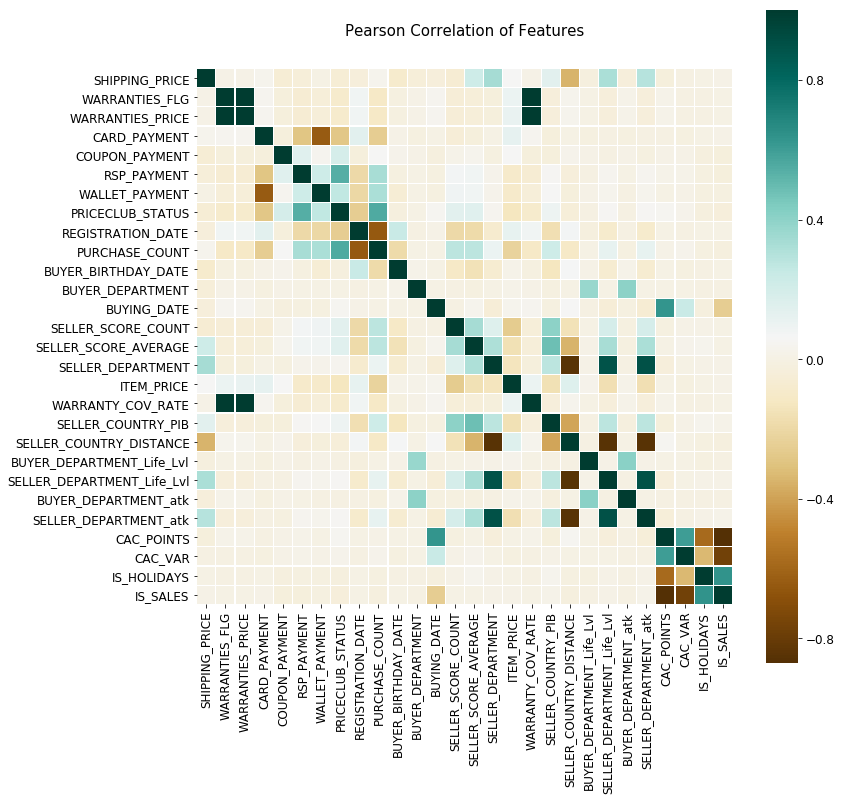

In [29]:
colormap = plt.cm.BrBG
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(corr_map,
            linewidths=0.1,
            vmax=1.0, 
            square=True, 
            cmap=colormap, 
            linecolor='white',
            annot=False)

En vrai c'est méga joli, mais c'est pas bon pour l'algorithme

Actuellement, il nous reste encore quatre variables catégorielles:
1. `SHIPPING_MODE`
2. `SELLER_COUNTRY`
3. `PRODUCT_TYPE`
4. `PRODUCT_FAMILY`

Mais bon, `SELLER_COUNTRY` a maintenant plusieurs représentations numériques, donc en vrai, il n'en reste que 3.

On va voir ce qu'on peut faire avec `PRODUCT_TYPE` dans le  `Notebook 3 Stat des Sellers et clients`

Mais quel teasing!

Et on oublie pas d'écrire les résultats de nos transformations.

In [30]:
filename_train = DATA_PROCESSED+"/train_notebook_2.csv"
filename_test = DATA_PROCESSED+"/test_notebook_2.csv"

try:
    os.remove(filename_train)
    os.remove(filename_test)
except:
    pass;

train_df.to_csv(filename_train, index=False, sep=";")
test_df.to_csv(filename_test, index=False, sep=";")